In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
class MultipleLinearRegression:
    def __init__(self, learning_rate=0.001, n_iterations=2000):
        self.coefficients = None  # Store model coefficients (intercept + slopes)
        self.MSE = None  
        self.r_squared = None 
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.loss_history = []  # To track loss during training
        
        # Statistical properties
        self.df_error = None # degree of freedom for error
        self.df_regression = None #degree of freedom for regression
        self.SSE = None
        self.SSR = None
        self.SST = None
        self.F_stat = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.X = X
        self.y = y

        n_samples, n_features = X.shape # as x.shape return rows (no. of samples) columns (no. of features) 
        X_b = np.hstack([np.ones((n_samples, 1)), X])  # Add column of 1s

        # Initialize coefficients (B) (including intercept) 
        self.coefficients = np.zeros(X_b.shape[1])

        # Gradient Descent
        for _ in range(self.n_iterations):
            y_pred = X_b @ self.coefficients
            residuals = y - y_pred

            gradient = -2 * X_b.T @ residuals / n_samples
            self.coefficients -= self.learning_rate * gradient

            self.loss_history.append(np.mean(residuals**2)) # Tracks how well the model is doing at each step.

        # Calculate final predictions and metrics
        y_pred = X_b @ self.coefficients
        residuals = y - y_pred

        self.SSE = np.sum(residuals**2)
        self.MSE = self.SSE / (n_samples - n_features - 1) # n-p 

        y_bar = np.mean(y)
        self.SST = np.sum((y - y_bar)**2)
        self.SSR = np.sum((y_pred - y_bar)**2)

        # R-squared (goodness of fit)
        self.r_squared = self.SSR / self.SST 

        self.df_regression = n_features
        self.df_error = n_samples - n_features - 1



    def predict(self, X):

         # Check if model is fitted
        if self.coefficients is None:
            raise ValueError("Model not fitted yet. Call fit() first")
        X = np.array(X)
        X_b = np.hstack([np.ones((X.shape[0], 1)), X])
        return X_b @ self.coefficients
    
    def plot(self,X,y):

        # Check if model is trained
        if self.coefficients is None:
            raise ValueError("The model has not been fitted yet")
        
        # Ensure X and y are numpy arrays
        X = np.array(X)
        y = np.array(y)
        
        # Create a 3D plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        # Scatter plot for actual data points
        ax.scatter(X[:, 0], X[:, 1], y, color='blue', label='Data points')
        
        # Plotting the regression plane
        x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 10)
        y_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 10)
        X1, Y1 = np.meshgrid(x_range, y_range)
        Z1 = self.coefficients[0] + self.coefficients[1] * X1 + self.coefficients[2] * Y1
        ax.plot_surface(X1, Y1, Z1, color='red', alpha=0.5)
        
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('y')
        ax.set_title('Multiple Linear Regression (3D)')
        plt.show()

    def anova_table(self):
        if self.coefficients is None:
            raise ValueError("The model has not been fitted yet.")
        
        # Degrees of freedom
        self.df_regression = len(self.coefficients) - 1  # Exclude intercept
        self.df_error = len(self.X) - len(self.coefficients)  # Residuals degrees of freedom
        df_total = len(self.X) - 1
        
        # Mean squares
        MSR = self.SSR / self.df_regression
        MSE = self.SSE / self.df_error
        
        # F-statistic
        self.F_stat = MSR / MSE
        
        # Assemble the ANOVA table
        anova_data = {
            'Source': ['Regression', 'Error', 'Total'],
            'Sum of Squares': [self.SSR, self.SSE, self.SST],
            'Degrees of Freedom': [self.df_regression, self.df_error, df_total],
            'Mean Square': [MSR, MSE, ""],
            'F-Statistic': [self.F_stat, "", ""]
        }
        
        return pd.DataFrame(anova_data)
    
    def hypothesis_test(self, alpha=0.05):
        """
        Perform a manual F-test for overall model significance.
        No use of scipy.stats. Uses an internal critical F-value table.
        """

        if not hasattr(self, 'SSR') or not hasattr(self, 'SSE'):
            raise ValueError("Model must be fitted before hypothesis testing.")

        # Mean squares
        MSR = self.SSR / self.df_regression
        MSE = self.SSE / self.df_error

        # Compute F-statistic
        self.F_stat = MSR / MSE

        # Approximate F-critical values for alpha=0.05
        f_table_95 = {
            (1, 10): 4.96, (1, 20): 4.35, (1, 30): 4.17, (1, 60): 4.00,
            (2, 10): 4.10, (2, 20): 3.49, (2, 30): 3.32, (2, 60): 3.15,
            (3, 10): 3.71, (3, 20): 3.10, (3, 30): 2.92, (3, 60): 2.76,
            (5, 30): 2.53, (5, 60): 2.39, (10, 60): 2.18
        }

        key = (self.df_regression, self.df_error)
        # Find the closest key if exact df pair isn't available
        closest_key = min(f_table_95.keys(), key=lambda k: abs(k[0] - self.df_regression) + abs(k[1] - self.df_error))
        F_critical = f_table_95[closest_key]

        # Print results
        print(f"F-statistic: {self.F_stat:.3f}")
        print(f"Critical F-value (approx for alpha={alpha}): {F_critical:.3f} [df1={closest_key[0]}, df2={closest_key[1]}]")

        if self.F_stat > F_critical:
            print("✅ Reject H0: There is a significant relationship between features and target.")
        else:
            print("❌ Fail to reject H0: No significant relationship detected.")



    def interval_estimation(self, alpha=0.05, sigma=None):
        """
        Manually compute confidence intervals for regression coefficients,
        using approximate t-critical values without scipy.stats.
        """

        if sigma is None:
            sigma = np.sqrt(self.MSE)  # Estimate residual standard deviation

        X_b = np.hstack([np.ones((self.X.shape[0], 1)), self.X])
        XtX_inv = np.linalg.inv(X_b.T @ X_b)
        var_beta = XtX_inv * self.MSE

        # Approximate t-critical values for alpha=0.05 (95% CI)
        t_table_95 = {
            1: 12.71, 2: 4.30, 3: 3.18, 4: 2.78, 5: 2.57, 6: 2.45, 7: 2.36,
            8: 2.31, 9: 2.26, 10: 2.23, 11: 2.20, 12: 2.18, 13: 2.16,
            14: 2.14, 15: 2.13, 20: 2.09, 25: 2.06, 30: 2.04, 40: 2.02,
            60: 2.00, 120: 1.98, 1000: 1.96  # Approaches normal Z=1.96
        }

        # Find closest df in table
        df = self.df_error
        closest_df = min(t_table_95.keys(), key=lambda x: abs(x - df))
        t_critical = t_table_95[closest_df]

        # Compute confidence intervals
        intervals = []
        for i, coef in enumerate(self.coefficients):
            se = np.sqrt(var_beta[i, i])  # Standard error
            margin = t_critical * se
            lower = coef - margin
            upper = coef + margin
            intervals.append((lower, upper))

        return pd.DataFrame(
            intervals,
            columns=["Lower Bound", "Upper Bound"],
            index=["Intercept"] + [f"X{i}" for i in range(1, self.X.shape[1] + 1)]
        )



In [71]:
df = pd.read_csv("D:/FCDS/Regression Analysis/Sections/DataSets/Student_Performance.csv")
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [72]:
df.isnull().sum()

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

In [73]:
print(df.duplicated().sum())

127


In [74]:
duplicate_rows = df[df.duplicated(keep=False)]  # Show all duplicates
print(duplicate_rows.sort_values(by=list(df.columns)))  # Group duplicates together

      Hours Studied  Previous Scores Extracurricular Activities  Sleep Hours  \
6975              1               41                         No            7   
9966              1               41                         No            7   
2225              1               42                        Yes            9   
4986              1               42                        Yes            9   
2647              1               57                         No            8   
...             ...              ...                        ...          ...   
8118              9               86                        Yes            6   
3482              9               87                         No            7   
4261              9               87                         No            7   
8214              9               87                         No            7   
9379              9               87                         No            7   

      Sample Question Papers Practiced 

In [75]:
df.sort_values('Performance Index', ascending=False, inplace=True)
df.drop_duplicates(inplace=True)

In [76]:
df['Extracurricular Activities'] = df['Extracurricular Activities'].map({'Yes': 1, 'No': 0})

In [77]:
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
2725,9,99,1,8,8,100.0
2070,9,98,1,4,5,100.0
145,9,98,1,7,7,100.0
2637,9,99,0,9,4,99.0
1157,8,99,1,8,9,99.0


In [78]:
# Split the data into features (X) and target (y)
X = df[['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced']]
y = df['Performance Index']

In [79]:
from sklearn.model_selection import train_test_split

# Split the data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [80]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [81]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [82]:
model = MultipleLinearRegression() 
model.fit(X_train, y_train)

In [83]:
print(f"Model Coefficients (intercept + slopes): {model.coefficients}")

Model Coefficients (intercept + slopes): [54.1401141   7.21534894 17.30825107  0.29834689  0.8102709   0.56287707]


In [84]:
y_pred = model.predict(X_test)
print(f"Predicted values: {y_pred}")

Predicted values: [48.65453896 91.01084662 26.55777014 ... 53.79902982 49.73694356
 52.01776169]


In [85]:
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comparison)

      Actual  Predicted
0       48.0  48.654539
1       93.0  91.010847
2       27.0  26.557770
3       57.0  54.835353
4       73.0  70.730879
...      ...        ...
1970    32.0  28.537425
1971    67.0  64.183217
1972    53.0  53.799030
1973    48.0  49.736944
1974    54.0  52.017762

[1975 rows x 2 columns]


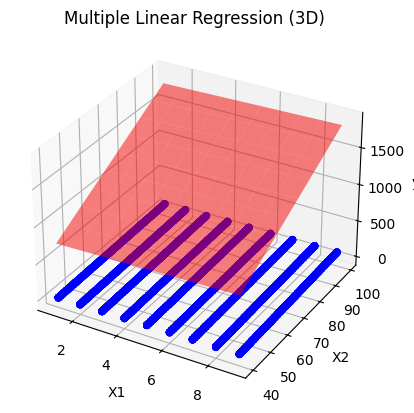

In [86]:
model.plot(X, y)

In [87]:
anova_table = model.anova_table()
print(anova_table)

       Source  Sum of Squares  Degrees of Freedom    Mean Square  \
0  Regression    2.776644e+06                   5  555328.741571   
1       Error    4.199052e+04                7892       5.320644   
2       Total    2.908263e+06                7897                  

     F-Statistic  
0  104372.475612  
1                 
2                 


In [88]:
model.hypothesis_test(alpha=0.05)

F-statistic: 104372.476
Critical F-value (approx for alpha=0.05): 2.390 [df1=5, df2=60]
✅ Reject H0: There is a significant relationship between features and target.


In [89]:
intervals = model.interval_estimation(alpha=0.05)
print("Confidence Intervals for Coefficients:")
print(intervals)

Confidence Intervals for Coefficients:
           Lower Bound  Upper Bound
Intercept    54.089242    54.190986
X1            7.164463     7.266235
X2           17.257371    17.359131
X3            0.247462     0.349232
X4            0.759387     0.861155
X5            0.511991     0.613763
